### NEURAL STYLE TRANSFER USING VGG19

512


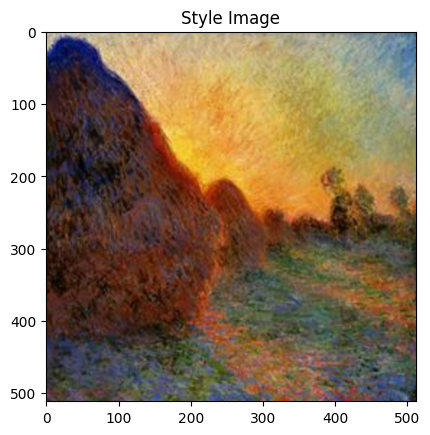

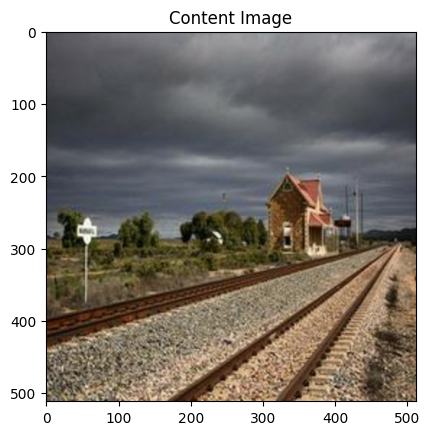

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 154MB/s]  


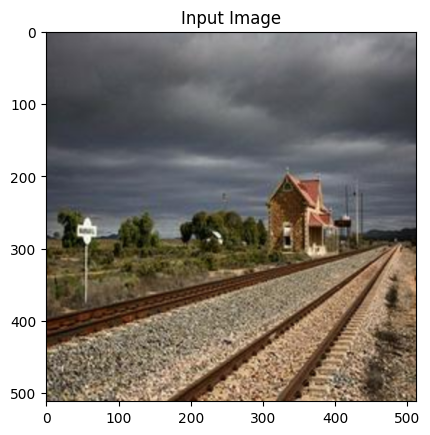

Building the style transfer model..


/tmp/ipykernel_35/3676267095.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_35/3676267095.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 60.428318 Content Loss: 7.983892

run [100]:
Style Loss : 16.201300 Content Loss: 8.122583

run [150]:
Style Loss : 8.931494 Content Loss: 7.107888

run [200]:
Style Loss : 5.527052 Content Loss: 6.357788

run [250]:
Style Loss : 3.747408 Content Loss: 5.802749

run [300]:
Style Loss : 2.835432 Content Loss: 5.345193

run [350]:
Style Loss : 2.118635 Content Loss: 5.054132

run [400]:
Style Loss : 1.536840 Content Loss: 4.836548

run [450]:
Style Loss : 1.179147 Content Loss: 4.652183

run [500]:
Style Loss : 1.002141 Content Loss: 4.469872

run [550]:
Style Loss : 0.887408 Content Loss: 4.319376

run [600]:
Style Loss : 0.802441 Content Loss: 4.185576

run [650]:
Style Loss : 0.742937 Content Loss: 4.073197

run [700]:
Style Loss : 0.695347 Content Loss: 3.974982

run [750]:
Style Loss : 0.655295 Content Loss: 3.897328

run [800]:
Style Loss : 0.629470 Content Loss: 3.836288

run [850]:
Style Loss : 0.606586 Content Loss: 3.786684

run [900]:
Style 

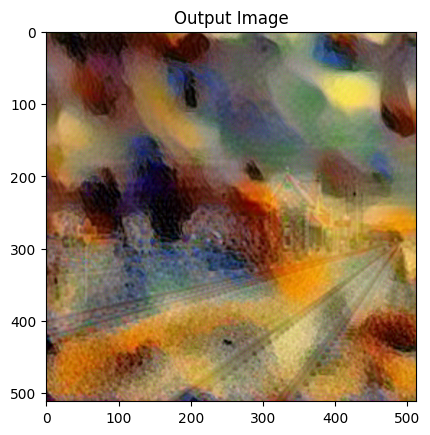

In [ ]:
# Importing Required Libraries
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


# This detect if cuda is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

print(imsize)
# scale imported image
# transform it into a torch tensor
loader = transforms.Compose([transforms.Resize(imsize),  transforms.ToTensor()])

# Helper function
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# Loading of images

style_img_path = "/kaggle/input/dataset/style.jpg"
content_img_path = "/kaggle/input/contentdataset/00fcff630e.jpg"

style_img = image_loader(style_img_path)
content_img = image_loader(content_img_path)


# Resize the style image to match the size of the content image
style_img = transforms.Resize(content_img.shape[-2:])(style_img)

assert style_img.size() == content_img.size(), "Style and content images must be of the same size"


unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

# Helper function to show the tensor as a PIL image
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Custom content loss
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()

        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# This is for the style loss
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

# Same structure as the content loss
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Importing the VGG 19 model like in the paper (here we set it to evaluation mode)
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG network are normalized with special values for the mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # losses
    content_losses = []
    style_losses = []


    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()


# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

# This type of optimizer was prefered by the author of the paper
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# It will create image that goes above 1 or below 0, however it will be normalized
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction to have the tensors between 0 and 1
    input_img.data.clamp_(0, 1)

    return input_img

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=3000)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()



In [ ]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


### CALCULATING THE TRAINABLE PARAMETERS

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
from tabulate import tabulate
import torchvision.models as models

# Define the neural network class
class StyleTransferModel(nn.Module):
    def __init__(self):
        super(StyleTransferModel, self).__init__()
        self.model = models.vgg19(pretrained=True).features.to(device)

    def forward(self, x):
        return self.model(x)


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StyleTransferModel().to(device)

# Print the summary of the model
summary(model, (3, 512, 512))  # Assuming input size (3, 512, 512)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

STYLE TRANSFER FOR TWO INPUT IMAGE USING VGG19

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


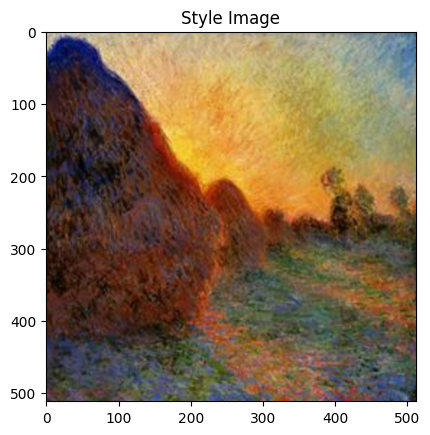

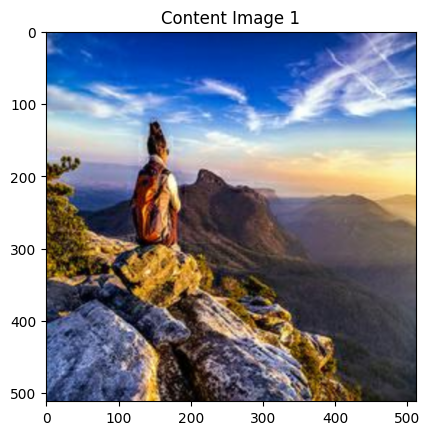

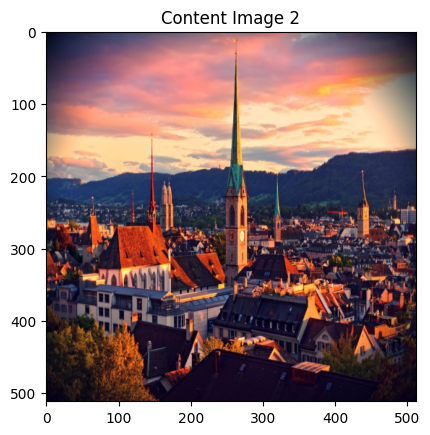

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Building the style transfer model..
Optimizing..


/tmp/ipykernel_35/3411179676.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_35/3411179676.py:114: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 39.343353 Content Loss: 13.054613

run [100]:
Style Loss : 15.858775 Content Loss: 10.040770

run [150]:
Style Loss : 10.207044 Content Loss: 7.203778

run [200]:
Style Loss : 6.214613 Content Loss: 6.032836

run [250]:
Style Loss : 3.746453 Content Loss: 5.340794

run [300]:
Style Loss : 2.660581 Content Loss: 4.766508

run [350]:
Style Loss : 1.799264 Content Loss: 4.356970

run [400]:
Style Loss : 1.362984 Content Loss: 4.069140

run [450]:
Style Loss : 1.037711 Content Loss: 3.858289

run [500]:
Style Loss : 0.822109 Content Loss: 3.692405

run [550]:
Style Loss : 0.693883 Content Loss: 3.564996

run [600]:
Style Loss : 0.619917 Content Loss: 3.462595

run [650]:
Style Loss : 0.576233 Content Loss: 3.391855

run [700]:
Style Loss : 0.552917 Content Loss: 3.326215

run [750]:
Style Loss : 0.540154 Content Loss: 3.272960

run [800]:
Style Loss : 0.534720 Content Loss: 3.234209

run [850]:
Style Loss : 0.514876 Content Loss: 3.203347

run [900]:
Style Loss : 0.5

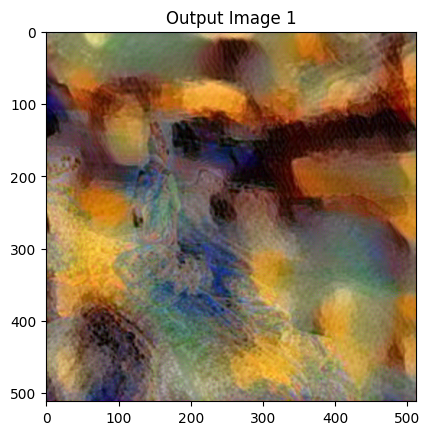

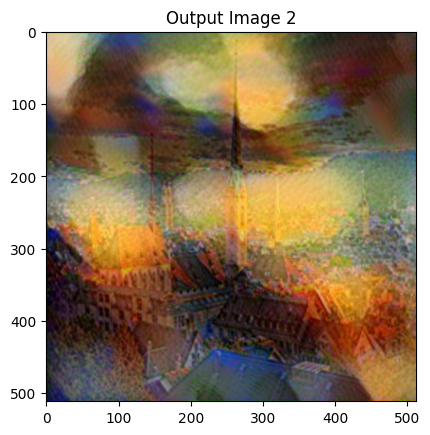

In [ ]:
# Importing required libraries
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy


# This detects if CUDA is available for GPU training, otherwise, it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

# Scale imported image and transform it into a torch tensor
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

# Helper function to load an image
def image_loader(image_name):
    image = Image.open(image_name)
    # Fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


# Loading the style image
style_img_path = "/kaggle/input/dataset/style.jpg"
style_img = image_loader(style_img_path)

# List of content image paths
content_img_paths = ["/kaggle/input/dataset/content.jpg", "/kaggle/input/123345/zurich.jpeg"]

# Loading and resizing content images
content_imgs = [image_loader(content_img_path) for content_img_path in content_img_paths]
content_imgs_resized = [transforms.Resize(style_img.shape[-2:])(content_img) for content_img in content_imgs]

# Asserting that style and content images must be of the same size
for content_img_resized in content_imgs_resized:
    assert style_img.size() == content_img_resized.size(), "Style and content images must be of the same size"


unloader = transforms.ToPILImage()  # Reconvert into PIL image

plt.ion()

# Helper function to show the tensor as a PIL image
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

for idx, content_img_resized in enumerate(content_imgs_resized):
    plt.figure()
    imshow(content_img_resized, title=f'Content Image {idx + 1}')

# Custom content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()

        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Style loss
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    features = input.view(a * b, c * d)  # Resize F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # Compute the gram product
    return G.div(a * b * c * d)

# Same structure as the content loss
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Importing the VGG 19 model like in the paper (here we set it to evaluation mode)
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG network is normalized with special values for the mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Define default layers to compute style/content losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Function to get the style model and losses
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_imgs,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # Normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []


    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # Add content loss
            target = model(content_imgs[0]).detach()  # Use the first content image for content loss
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Add style loss
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Function to perform neural style transfer
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_imgs, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_imgs)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

# Create a list to store the outputs
outputs = []

# Perform style transfer for each content image
for idx, content_img_resized in enumerate(content_imgs_resized):
    input_img = content_img_resized.clone()
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                [content_img_resized], style_img, input_img, num_steps=3000)
    outputs.append(output)

# Display the output images
for idx, output in enumerate(outputs):
    plt.figure()
    imshow(output, title=f'Output Image {idx + 1}')

plt.ioff()
plt.show()


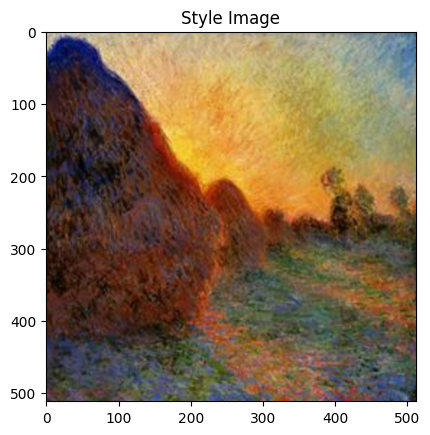

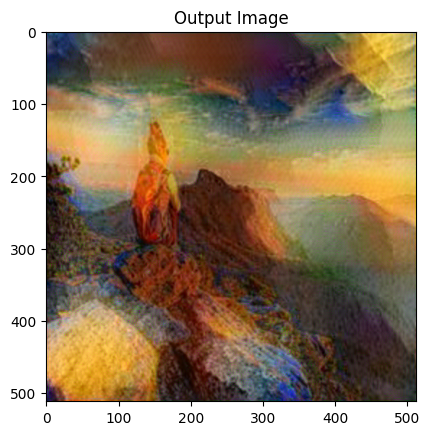

In [ ]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(output, title='Output Image')

### STATISTICAL VISUALIZATION

Style Image Mean: [0.4815074  0.38417718 0.26199228]
Style Image Standard Deviation: [0.24061048 0.21062101 0.15002263]
Output Image Mean: [0.4771131  0.38075984 0.2585379 ]
Output Image Standard Deviation: [0.24575846 0.2120679  0.1563917 ]


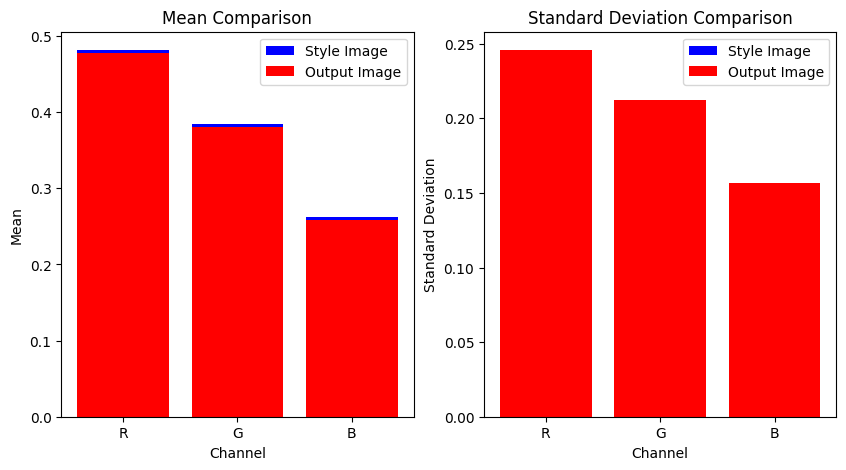

In [ ]:
import numpy as np

# Convert tensors to numpy arrays
style_np = style_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
output_np = output.detach().squeeze(0).permute(1, 2, 0).cpu().numpy()

# Calculate mean and standard deviation
style_mean = np.mean(style_np, axis=(0, 1))
style_std = np.std(style_np, axis=(0, 1))
output_mean = np.mean(output_np, axis=(0, 1))
output_std = np.std(output_np, axis=(0, 1))

# Print mean and standard deviation
print("Style Image Mean:", style_mean)
print("Style Image Standard Deviation:", style_std)
print("Output Image Mean:", output_mean)
print("Output Image Standard Deviation:", output_std)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting mean comparison
plt.subplot(1, 2, 1)
plt.bar(['R', 'G', 'B'], style_mean, color='blue', label='Style Image')
plt.bar(['R', 'G', 'B'], output_mean, color='red', label='Output Image')
plt.title('Mean Comparison')
plt.xlabel('Channel')
plt.ylabel('Mean')
plt.legend()

# Plotting standard deviation comparison
plt.subplot(1, 2, 2)
plt.bar(['R', 'G', 'B'], style_std, color='blue', label='Style Image')
plt.bar(['R', 'G', 'B'], output_std, color='red', label='Output Image')
plt.title('Standard Deviation Comparison')
plt.xlabel('Channel')
plt.ylabel('Standard Deviation')
plt.legend()

plt.show()


In [ ]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.


### EVALUATION

In [ ]:
import cv2
from skimage.metrics import structural_similarity as ssim

# Resize the style and output images to 128x128
style_img_resized = cv2.resize(style_np, (128, 128))
output_img_resized = cv2.resize(output_np, (128, 128))

# Calculate the SSIM score with the resized images
ssim_score_resized = ssim(style_img_resized, output_img_resized, win_size=3, data_range=1.0, multichannel=True)

print("SSIM Score between Style and Output Images (resized):", ssim_score_resized)


SSIM Score between Style and Output Images (resized): 0.3399184883132734


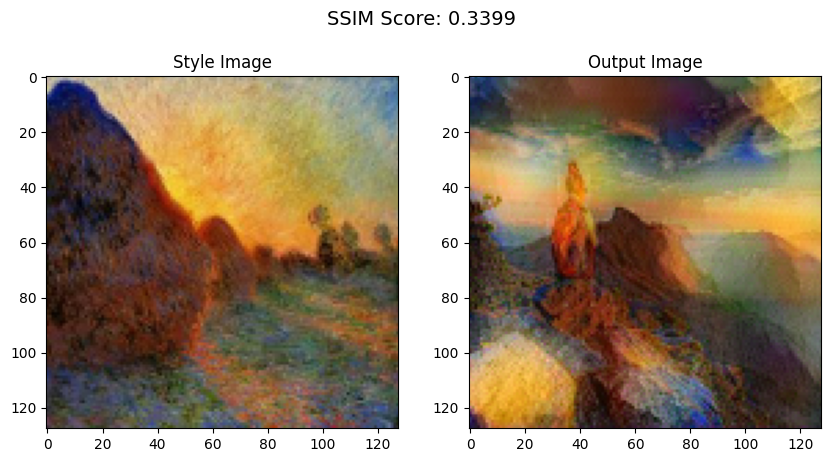

In [ ]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Assuming style_img_resized and output_img_resized are the resized style and output images
# Calculate the SSIM score between the resized images
ssim_score_resized = ssim(style_img_resized, output_img_resized, win_size=3, data_range=1.0, multichannel=True)
# Plot the original style and output images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(style_img_resized)
plt.title('Style Image')

plt.subplot(1, 2, 2)
plt.imshow(output_img_resized)
plt.title('Output Image')

plt.suptitle(f'SSIM Score: {ssim_score_resized:.4f}', fontsize=14)
plt.show()
